# *Import libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# *Read the training data*

In [2]:
# Read training data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('There are ', train_data.shape[1], 'attributes and', train_data.shape[0], 'records in the dataset.')

There are  12 attributes and 891 records in the dataset.


In [4]:
# Check the data types of each columns.
print(train_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


# *Data wrangling*

In [5]:
# Calculate the percentage of missing values of each column.
(train_data.isnull().sum()/train_data.shape[0]*100).to_frame().rename(columns={0: 'Null%'})

,Null%
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


Because the 'Cabin' column has missing values about 77% high, thus this attribute is not being consider a factor in this analysis. We drop it from the data with other non-relevant columns.

In [6]:
# Drop the non-relevant columns.
train_df = train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [7]:
print('There are ', train_df.shape[1], 'attributes and', train_df.shape[0], 'records in the dataset.')

There are  9 attributes and 891 records in the dataset.


In [8]:
# Replace missing value with mean in the "Age" column.
avg_age = train_df['Age'].mean(axis=0)
train_df['Age'].replace(np.nan, avg_age, inplace=True)
print('Total missing values in "Age" column is: ', train_df['Age'].isnull().sum())

Total missing values in "Age" column is:  0


For a few missing values in the 'Embarked' column, I will replace them with the frequency due to it being the most probable.

In [9]:
embarked_freq = train_df['Embarked'].value_counts().idxmax()
train_df['Embarked'].replace(np.nan, embarked_freq, inplace=True)
print('Total missing values in "Embarked" column is: ', train_df['Embarked'].isnull().sum())

Total missing values in "Embarked" column is:  0


In [10]:
# Check the missing values again
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

# *EDA*

**Numerical attributes**

In [11]:
train_df[['Age', 'SibSp', 'Parch', 'Fare']].astype(float).describe()

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,13.002015,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400
50%,29.699118,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


* The oldest passenger is 80 years old; the youngest passenger is minor than 1.  
* Most passengers are young (or young adults), the mean age is around 30.

**Categorical attributes**

In [12]:
train_df[['Survived', 'Pclass', 'Sex', 'Embarked']].astype('object').describe(include=['object'])

,Survived,Pclass,Sex,Embarked
count,891,891,891,891
unique,2,3,2,3
top,0,3,male,S
freq,549,491,577,646


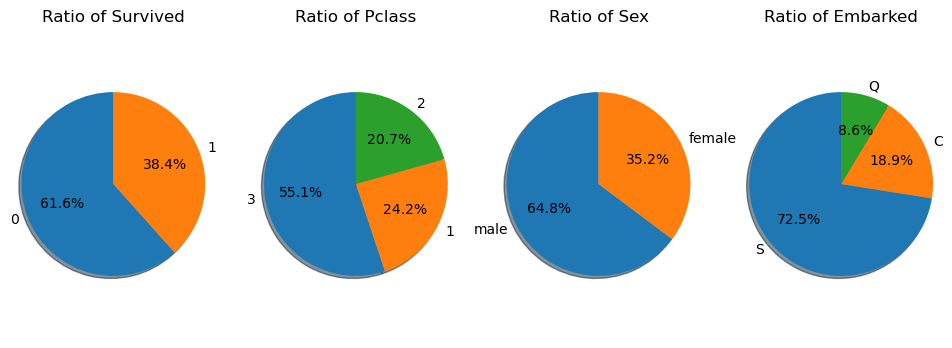

In [13]:
# The proportion of categories for these attribute in pie chart.
def plot_pie_chart(attribute):
    fig, ax = plt.subplots(1, len(attribute), figsize=(12, 4))
    
    for i, attr in enumerate(attribute):
        attr_count = train_df[attr].value_counts()
        ax[i].pie(attr_count, labels=attr_count.index, startangle=90, autopct='%1.1f%%', shadow=True)
        ax[i].axis('equal')
        ax[i].set_title(f'Ratio of {attr}')
        
    plt.show()

plot_pie_chart(['Survived', 'Pclass', 'Sex', 'Embarked'])

Male passengers are about double of female passengers, where values are similar to the survival rate.

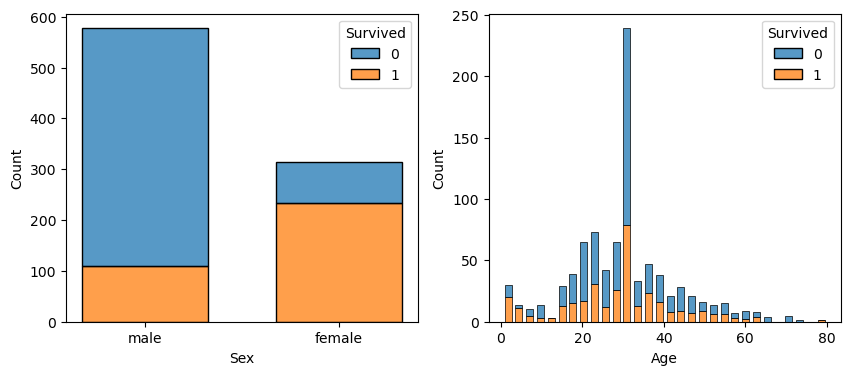

In [14]:
# Survival rate of male and female passengers.
fig, (ax0, ax1)=plt.subplots(1,2,figsize=(10,4))
sns.histplot(data=train_df, x='Sex', hue='Survived', multiple='stack', shrink=0.65, ax=ax0)
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack', shrink=0.65, ax=ax1)
plt.show()

* Male and female fatality rates vary widely from the histogram, with most males dying in shipwrecks despite more male passengers.
* Most of the passengers were around 30 years old, and this age range had the highest number of deaths.

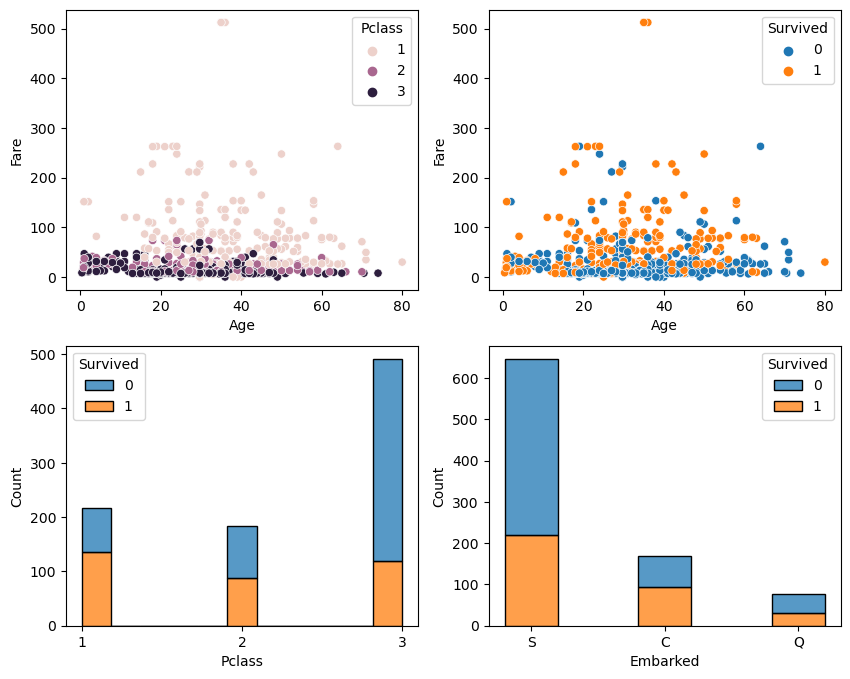

In [15]:
# Age vs. Fare scatter plot and classified by ticket class and survival.
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Pclass', ax=ax0)
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived', ax=ax1)
sns.histplot(data=train_df, x='Pclass', hue='Survived', multiple='stack', ax=ax2)
ax2.set_xticks([1,2,3])
sns.histplot(data=train_df, x='Embarked', hue='Survived', multiple='stack', shrink=0.4, ax=ax3)
plt.show()

* As expected, the upper class ticket is more expensive and less passenger as the ticket fare rises.
* From the second plot, however, the higher fare ticket seems have a slightly higher survival rate.
* Most people are onboard at Southampton and have highest number of deaths.
* The lower class have more unsurvived passengers, it is conceivable that the cabin where this class is located has the highest population density, so a shipwreck is most likely to cause the greatest chaos.


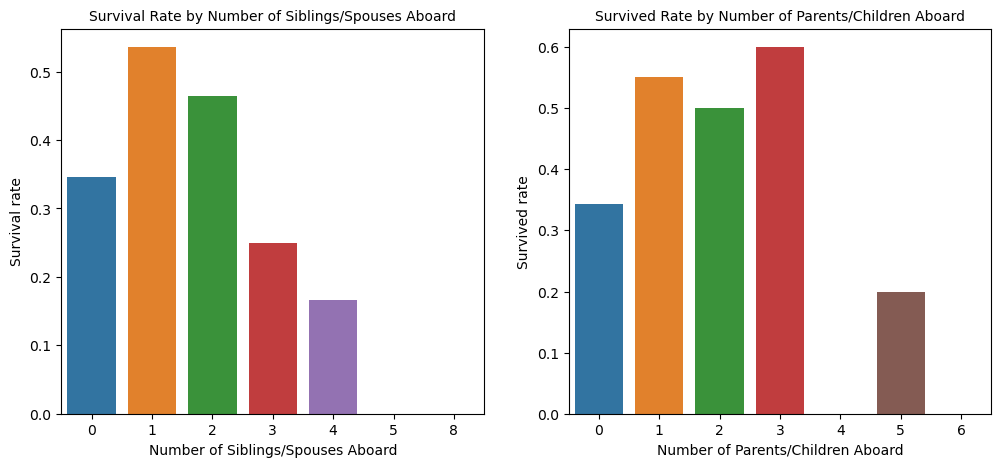

In [16]:
# Calculate the surival rate by number of siblings/spouses or parents/children aboard
fig, (ax0, ax1)=plt.subplots(1, 2, figsize=(12,5))

SibSp_survival_rate = train_df.groupby('SibSp')['Survived'].mean()
sns.barplot(x=SibSp_survival_rate.index, y=SibSp_survival_rate.values, ax=ax0)
ax0.set_xlabel('Number of Siblings/Spouses Aboard')
ax0.set_ylabel('Survival rate')
ax0.set_title('Survival Rate by Number of Siblings/Spouses Aboard', fontsize=10)

Parch_survival_rate = train_df.groupby('Parch')['Survived'].mean()
sns.barplot(x=Parch_survival_rate.index, y=Parch_survival_rate.values, ax=ax1)
ax1.set_xlabel('Number of Parents/Children Aboard')
ax1.set_ylabel('Survived rate')
ax1.set_title('Survived Rate by Number of Parents/Children Aboard', fontsize=10)

plt.show()

* We can see the passenger have 1 or 2 Siblings/Spouses have highest survival rate, but the survival rate is sharply decreased as the number of Siblings/Spouses increased.
* The same situation also happens to Parent/Children, passengers with fewer Parent/Children have a higher survival rate, and vice versa, the survival rate is very low.

Surprisingly, the survival rate of the passenger who don't have companions is not the highest. This situation may be explained by that passengers with companions need to take care of their companions, while passengers without companions may be more inclined to help others, putting themselves in danger.

In [17]:
# Replace the non-numerial values, Emparked: C: 1, Q: 2, S: 3; Sex: female: 1, male: 0.
train_df2 = train_df.replace({'C': 1, 'Q': 2, 'S': 3, 'female': 1, 'male': 0})
train_df2 = train_df2.astype(float)
# Check the Pearson correlation of each attributes.
train_df2.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.033207,-0.057527,-0.001652,0.012658,0.013128
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.069809,-0.035322,0.081629,0.257307,-0.167675
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.331339,0.083081,0.018443,-0.549500,0.162098
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.084153,0.114631,0.245489,0.182333,-0.108262
Age,0.033207,-0.069809,-0.331339,-0.084153,1.000000,-0.232625,-0.179191,0.091566,-0.026749
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.232625,1.000000,0.414838,0.159651,0.068230
Parch,-0.001652,0.081629,0.018443,0.245489,-0.179191,0.414838,1.000000,0.216225,0.039798
Fare,0.012658,0.257307,-0.549500,0.182333,0.091566,0.159651,0.216225,1.000000,-0.224719
Embarked,0.013128,-0.167675,0.162098,-0.108262,-0.026749,0.068230,0.039798,-0.224719,1.000000


Pearson correlation shown attribute 'Sex' have the highest correlation to the target 'Survived'.

### One Hot Encoder

In [18]:
train_onehot = pd.get_dummies(data=train_df, columns=['Sex', 'Pclass', 'Embarked'])
train_onehot.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


### Data Separating

In [19]:
X = train_onehot.drop(['Survived'], axis=1).astype(float)
X.head()

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,35.0,1.0,0.0,53.1000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [20]:
Y = train_onehot['Survived'].to_numpy()
Y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

### Data Normalization

In [21]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X

array([[-1.73010796, -0.5924806 ,  0.43279337, ..., -0.48204268,
        -0.30756234,  0.61583843],
       [-1.72622007,  0.63878901,  0.43279337, ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [-1.72233219, -0.2846632 , -0.4745452 , ..., -0.48204268,
        -0.30756234,  0.61583843],
       ...,
       [ 1.72233219,  0.        ,  0.43279337, ..., -0.48204268,
        -0.30756234,  0.61583843],
       [ 1.72622007, -0.2846632 , -0.4745452 , ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [ 1.73010796,  0.17706291, -0.4745452 , ..., -0.48204268,
         3.25137334, -1.62380254]])

### Training Data Split
Use for in-model training.

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=16)
print('Shape of training set: ', X_train.shape)
print('Shape of test set: ', X_test.shape)

Shape of training set:  (712, 13)
Shape of test set:  (179, 13)


# *Model Training*

### *Logistic Regression*

In [23]:
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=8)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=8, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [24]:
print('Best hyperparameters: ', logreg_cv.best_params_)
print('Accuracy of Logistic Regression on training data: {:.1f}'.format(logreg_cv.best_score_*100), '%')

Best hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy of Logistic Regression on training data: 81.5 %


In [25]:
logreg_acc = logreg_cv.score(X_test, Y_test)
print('Accuracy of Logistic Regression on test data: {:.1f}'.format(logreg_acc*100), '%')

Accuracy of Logistic Regression on test data: 74.9 %


### *Decision Tree*

In [26]:
parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)], 'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=8)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=8, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [27]:
print('Best hyperparameters: ', tree_cv.best_params_)
print('Accuracy of Decision Tree on training data: {:.1f}'.format(tree_cv.best_score_*100), '%')

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Accuracy of Decision Tree on training data: 83.1 %


In [28]:
tree_acc = tree_cv.score(X_test, Y_test)
print('Accuracyof Decision Tree on test data: {:.1f}'.format(tree_acc*100), '%')

Accuracyof Decision Tree on test data: 76.0 %


### *Random Forest*

In [29]:
parameters = {'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 
              'max_depth': [2*n for n in range(1,10)], 'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, parameters, cv=8)
rf_cv.fit(X_train, Y_train)

GridSearchCV(cv=8, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]})

In [30]:
print('Best hyperparameters: ', rf_cv.best_params_)
print('Accuracy of Random Forest on training data: {:.1f}'.format(rf_cv.best_score_*100), '%')

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy of Random Forest on training data: 84.4 %


In [31]:
rf_acc = rf_cv.score(X_test, Y_test)
print('Accuracyof Random Forest on test data: {:.1f}'.format(rf_acc*100), '%')

Accuracyof Random Forest on test data: 77.7 %


### *K-Nearest Neighbor*

In [32]:
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
knn=KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters, cv=8)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=8, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [33]:
print('Best hyperparameters: ', knn_cv.best_params_)
print('Accuracy of k-Nearest Neighbor on training data: {:.1f}'.format(knn_cv.best_score_*100), '%')

Best hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1}
Accuracy of k-Nearest Neighbor on training data: 82.3 %


In [34]:
knn_acc = knn_cv.score(X_test, Y_test)
print('Accuracyof Decision Tree on test data: {:.1f}'.format(knn_acc*100), '%')

Accuracyof Decision Tree on test data: 76.0 %


### *Training Results*

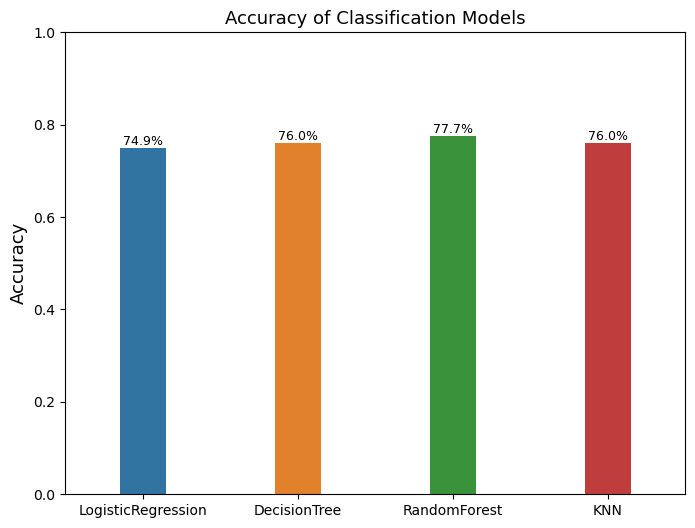

In [36]:
acc_results={'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN'],
             'Accuracy': [logreg_acc, tree_acc, rf_acc, knn_acc]}
accuracy = pd.DataFrame(acc_results)

plt.figure(figsize=(8,6))
sns.barplot(data=accuracy, x = 'Model', y='Accuracy', width=0.3)
plt.title('Accuracy of Classification Models', fontsize=13)
plt.xlabel('')
plt.ylabel('Accuracy', fontsize=13)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

for index, row in accuracy.iterrows():
    label = '{:.1f}%'.format(float(row['Accuracy'])*100)
    plt.annotate(label, xy=(index, row['Accuracy']), ha='center', va='bottom', fontsize=9)

plt.show()

Random Forest model have the best accuracy.

# Prediction

### Test data processing

In [37]:
# Read test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:
print('There are ', test_data.shape[1], 'attributes and', test_data.shape[0], 'records in the dataset.')

There are  11 attributes and 418 records in the dataset.


In [39]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [40]:
# Drop the non-relevant columns.
test_df = test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [41]:
# Missing values
test_df['Embarked'].replace(np.nan, test_df['Embarked'].value_counts().idxmax(), inplace=True)
test_df['Age'].replace(np.nan, avg_age, inplace=True)
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [42]:
# OneHotEncoder
test_onehot = pd.get_dummies(data=test_df, columns=['Sex', 'Pclass', 'Embarked'])
# Normalization
transform = preprocessing.StandardScaler()
test_norm = transform.fit_transform(test_onehot).astype(float)

In [43]:
print('Type: ', test_norm.dtype, '; Shape: ', test_norm.shape)

Type:  float64 ; Shape:  (418, 13)


In [44]:
yhat = rf_cv.predict(test_norm)
yhat

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [45]:
output = pd.DataFrame({"PassengerId": test_data["PassengerId"], "Survived": yhat})

In [48]:
output.to_csv('submission.csv', index=False)